In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm



In [2]:
train_dataset_path = 'C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\train'
val_dataset_path = 'C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\val'


In [3]:

# Define transformations for the training and validation sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Ensures the data is converted to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Ensures the data is converted to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dataset_path, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [4]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to output 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\PC\anaconda3\envs\crnn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\anaconda3\envs\crnn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# Training function with progress bar and metric tracking
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    train_precision_history = []
    val_precision_history = []
    train_recall_history = []
    val_recall_history = []
    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()  # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch}/{num_epochs - 1}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_precision = precision_score(all_labels, all_preds, average='weighted')
            epoch_recall = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1 Score: {epoch_f1:.4f}')

            # Save the metrics
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                train_precision_history.append(epoch_precision)
                train_recall_history.append(epoch_recall)
                train_f1_history.append(epoch_f1)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_precision_history.append(epoch_precision)
                val_recall_history.append(epoch_recall)
                val_f1_history.append(epoch_f1)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history

# Train the model
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=25)


Epoch 0/24
----------


train 0/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.4589 Acc: 0.8245 Precision: 0.8248 Recall: 0.8245 F1 Score: 0.8245


val 0/24: 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


val Loss: 1.6988 Acc: 0.6935 Precision: 0.7473 Recall: 0.6935 F1 Score: 0.6562
Epoch 1/24
----------


train 1/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.2834 Acc: 0.8870 Precision: 0.8877 Recall: 0.8870 F1 Score: 0.8868


val 1/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.7508 Acc: 0.7742 Precision: 0.8307 Recall: 0.7742 F1 Score: 0.7785
Epoch 2/24
----------


train 2/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.2565 Acc: 0.9096 Precision: 0.9102 Recall: 0.9096 F1 Score: 0.9097


val 2/24: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


val Loss: 0.3474 Acc: 0.8925 Precision: 0.8998 Recall: 0.8925 F1 Score: 0.8876
Epoch 3/24
----------


train 3/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.1867 Acc: 0.9395 Precision: 0.9393 Recall: 0.9395 F1 Score: 0.9394


val 3/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.2993 Acc: 0.8710 Precision: 0.8809 Recall: 0.8710 F1 Score: 0.8553
Epoch 4/24
----------


train 4/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.1642 Acc: 0.9422 Precision: 0.9417 Recall: 0.9422 F1 Score: 0.9418


val 4/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.2029 Acc: 0.9355 Precision: 0.9480 Recall: 0.9355 F1 Score: 0.9359
Epoch 5/24
----------


train 5/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.1646 Acc: 0.9402 Precision: 0.9401 Recall: 0.9402 F1 Score: 0.9401


val 5/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.5357 Acc: 0.8065 Precision: 0.8572 Recall: 0.8065 F1 Score: 0.8050
Epoch 6/24
----------


train 6/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.1298 Acc: 0.9501 Precision: 0.9503 Recall: 0.9501 F1 Score: 0.9502


val 6/24: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


val Loss: 0.5261 Acc: 0.8548 Precision: 0.8794 Recall: 0.8548 F1 Score: 0.8524
Epoch 7/24
----------


train 7/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1766 Acc: 0.9382 Precision: 0.9380 Recall: 0.9382 F1 Score: 0.9380


val 7/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.1831 Acc: 0.9247 Precision: 0.9412 Recall: 0.9247 F1 Score: 0.9242
Epoch 8/24
----------


train 8/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.1323 Acc: 0.9548 Precision: 0.9549 Recall: 0.9548 F1 Score: 0.9548


val 8/24: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


val Loss: 0.1188 Acc: 0.9516 Precision: 0.9517 Recall: 0.9516 F1 Score: 0.9510
Epoch 9/24
----------


train 9/24: 100%|██████████| 47/47 [00:18<00:00,  2.55it/s]


train Loss: 0.0845 Acc: 0.9714 Precision: 0.9715 Recall: 0.9714 F1 Score: 0.9714


val 9/24: 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


val Loss: 0.1798 Acc: 0.9194 Precision: 0.9193 Recall: 0.9194 F1 Score: 0.9170
Epoch 10/24
----------


train 10/24: 100%|██████████| 47/47 [00:18<00:00,  2.55it/s]


train Loss: 0.0893 Acc: 0.9648 Precision: 0.9648 Recall: 0.9648 F1 Score: 0.9647


val 10/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.1884 Acc: 0.9247 Precision: 0.9311 Recall: 0.9247 F1 Score: 0.9249
Epoch 11/24
----------


train 11/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0951 Acc: 0.9674 Precision: 0.9674 Recall: 0.9674 F1 Score: 0.9674


val 11/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.1091 Acc: 0.9677 Precision: 0.9680 Recall: 0.9677 F1 Score: 0.9675
Epoch 12/24
----------


train 12/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0648 Acc: 0.9834 Precision: 0.9834 Recall: 0.9834 F1 Score: 0.9834


val 12/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.1862 Acc: 0.9355 Precision: 0.9363 Recall: 0.9355 F1 Score: 0.9357
Epoch 13/24
----------


train 13/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0883 Acc: 0.9767 Precision: 0.9768 Recall: 0.9767 F1 Score: 0.9767


val 13/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.2834 Acc: 0.9301 Precision: 0.9379 Recall: 0.9301 F1 Score: 0.9319
Epoch 14/24
----------


train 14/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0751 Acc: 0.9754 Precision: 0.9755 Recall: 0.9754 F1 Score: 0.9754


val 14/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.1118 Acc: 0.9570 Precision: 0.9581 Recall: 0.9570 F1 Score: 0.9570
Epoch 15/24
----------


train 15/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0506 Acc: 0.9854 Precision: 0.9853 Recall: 0.9854 F1 Score: 0.9853


val 15/24: 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


val Loss: 0.2135 Acc: 0.9355 Precision: 0.9475 Recall: 0.9355 F1 Score: 0.9372
Epoch 16/24
----------


train 16/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0370 Acc: 0.9880 Precision: 0.9880 Recall: 0.9880 F1 Score: 0.9880


val 16/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.0638 Acc: 0.9839 Precision: 0.9854 Recall: 0.9839 F1 Score: 0.9840
Epoch 17/24
----------


train 17/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0429 Acc: 0.9847 Precision: 0.9851 Recall: 0.9847 F1 Score: 0.9847


val 17/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.2070 Acc: 0.9355 Precision: 0.9366 Recall: 0.9355 F1 Score: 0.9348
Epoch 18/24
----------


train 18/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.1026 Acc: 0.9654 Precision: 0.9654 Recall: 0.9654 F1 Score: 0.9654


val 18/24: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


val Loss: 0.2348 Acc: 0.9355 Precision: 0.9369 Recall: 0.9355 F1 Score: 0.9359
Epoch 19/24
----------


train 19/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.1045 Acc: 0.9621 Precision: 0.9622 Recall: 0.9621 F1 Score: 0.9621


val 19/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.1746 Acc: 0.9355 Precision: 0.9359 Recall: 0.9355 F1 Score: 0.9343
Epoch 20/24
----------


train 20/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0465 Acc: 0.9840 Precision: 0.9840 Recall: 0.9840 F1 Score: 0.9840


val 20/24: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


val Loss: 0.0986 Acc: 0.9624 Precision: 0.9629 Recall: 0.9624 F1 Score: 0.9624
Epoch 21/24
----------


train 21/24: 100%|██████████| 47/47 [00:18<00:00,  2.51it/s]


train Loss: 0.0231 Acc: 0.9947 Precision: 0.9947 Recall: 0.9947 F1 Score: 0.9947


val 21/24: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


val Loss: 0.0778 Acc: 0.9731 Precision: 0.9737 Recall: 0.9731 F1 Score: 0.9731
Epoch 22/24
----------


train 22/24: 100%|██████████| 47/47 [00:18<00:00,  2.55it/s]


train Loss: 0.0180 Acc: 0.9947 Precision: 0.9947 Recall: 0.9947 F1 Score: 0.9947


val 22/24: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


val Loss: 0.0999 Acc: 0.9677 Precision: 0.9712 Recall: 0.9677 F1 Score: 0.9681
Epoch 23/24
----------


train 23/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0202 Acc: 0.9934 Precision: 0.9934 Recall: 0.9934 F1 Score: 0.9934


val 23/24: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


val Loss: 0.1250 Acc: 0.9624 Precision: 0.9628 Recall: 0.9624 F1 Score: 0.9615
Epoch 24/24
----------


train 24/24: 100%|██████████| 47/47 [00:18<00:00,  2.54it/s]


train Loss: 0.0371 Acc: 0.9914 Precision: 0.9914 Recall: 0.9914 F1 Score: 0.9914


val 24/24: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]

val Loss: 0.1870 Acc: 0.9516 Precision: 0.9519 Recall: 0.9516 F1 Score: 0.9503


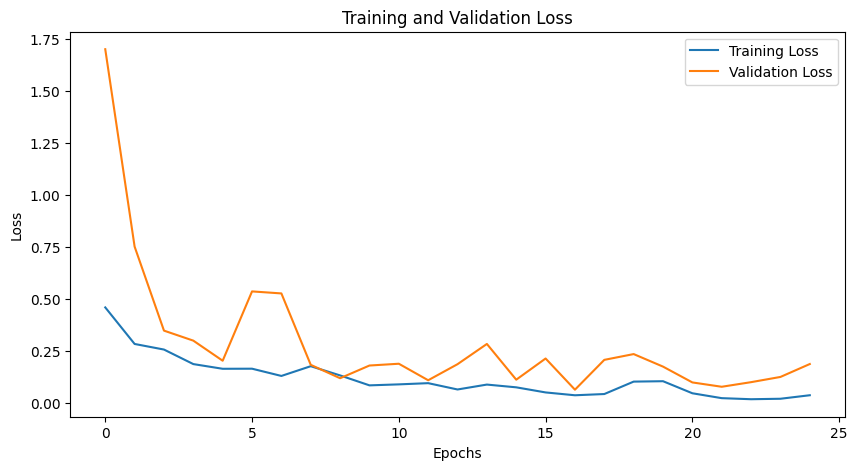

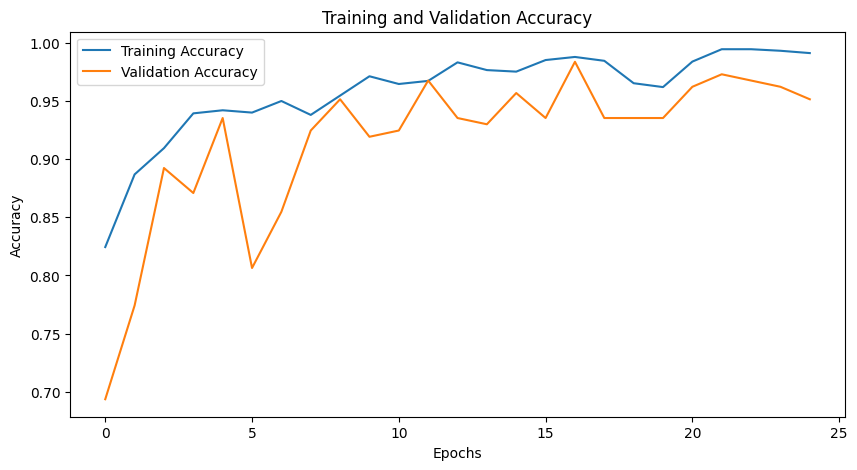

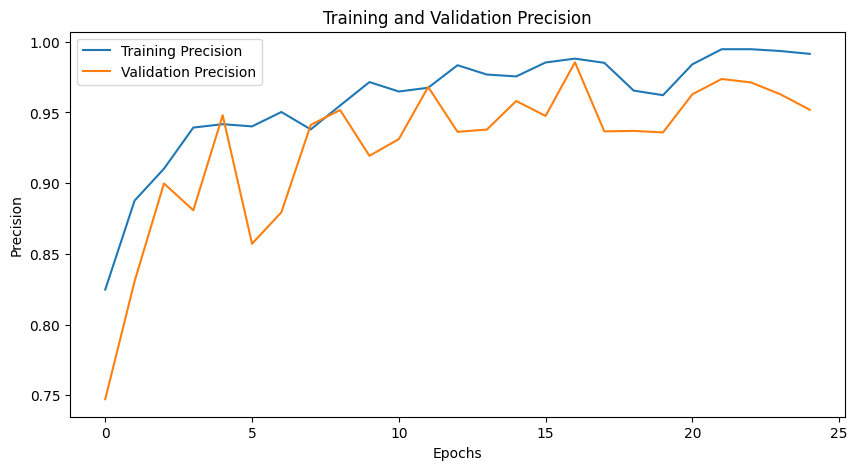

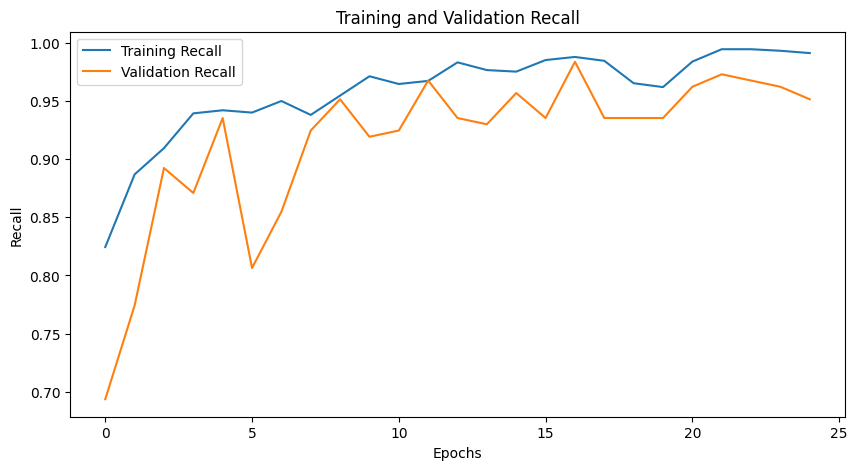

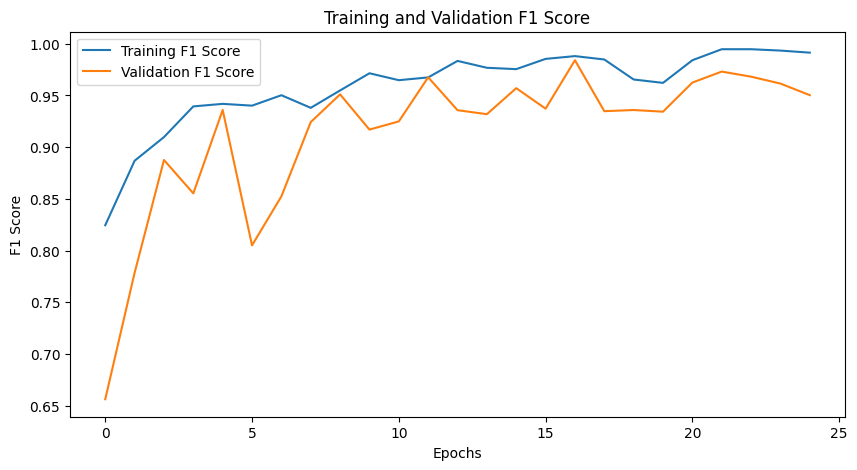

In [7]:
import numpy as np

# Convert tensor histories to numpy arrays
train_acc_history = np.array([x.cpu() for x in train_acc_history])
val_acc_history = np.array([x.cpu() for x in val_acc_history])
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation precision
plt.figure(figsize=(10, 5))
plt.plot(train_precision_history, label='Training Precision')
plt.plot(val_precision_history, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot the training and validation recall
plt.figure(figsize=(10, 5))
plt.plot(train_recall_history, label='Training Recall')
plt.plot(val_recall_history, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot the training and validation F1 score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_history, label='Training F1 Score')
plt.plot(val_f1_history, label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


In [8]:
# Save the trained model to a specified path
save_path = 'C:\\Users\\PC\\Desktop\\lisnen_research_files\\audio_research_crnn_files\\model_weights\\resnet_50.pth'
torch.save(model.state_dict(), save_path)

# testing the model on test data

In [9]:
# Define the transformations for the test set
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset_path = 'C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\test'
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []
    wrong_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect wrong predictions
            wrong_indices = np.where(preds.cpu().numpy() != labels.cpu().numpy())[0]
            for idx in wrong_indices:
                wrong_predictions.append((inputs.cpu()[idx], preds.cpu().numpy()[idx], labels.cpu().numpy()[idx]))

    accuracy = running_corrects.double() / len(dataloader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    
    return wrong_predictions,all_labels,all_preds

# Evaluate the model on the test data
class_names = ['Baby Cry','Door Bell','Door Knock', 'Fire Alarm']
wrong_predictions = evaluate_model(model, test_loader, class_names)




Test Accuracy: 0.9430
Test Precision: 0.9420
Test Recall: 0.9430
Test F1 Score: 0.9417


# confusion matrix

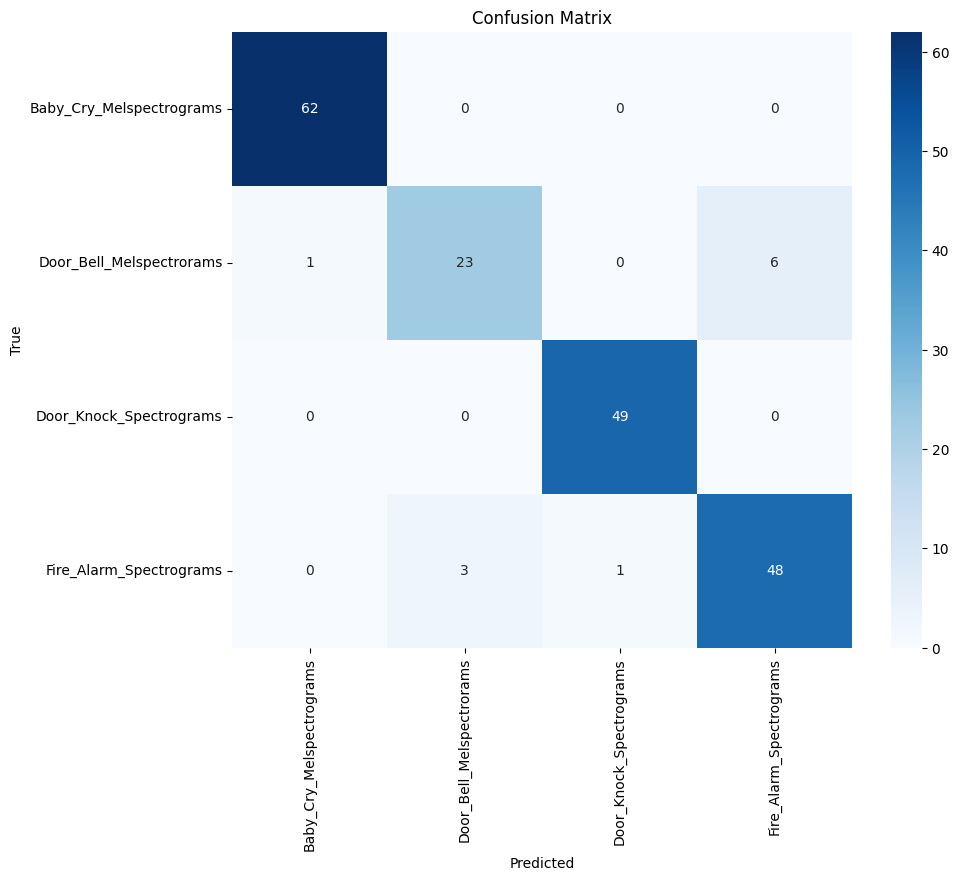

                          precision    recall  f1-score   support

Baby_Cry_Melspectrograms       0.98      1.00      0.99        62
Door_Bell_Melspectrorams       0.88      0.77      0.82        30
 Door_Knock_Spectrograms       0.98      1.00      0.99        49
 Fire_Alarm_Spectrograms       0.89      0.92      0.91        52

                accuracy                           0.94       193
               macro avg       0.93      0.92      0.93       193
            weighted avg       0.94      0.94      0.94       193

Class: Baby_Cry_Melspectrograms
Precision: 0.9841
Recall: 1.0000
F1 Score: 0.9920
Support: 62.0
--------------------
Class: Door_Bell_Melspectrorams
Precision: 0.8846
Recall: 0.7667
F1 Score: 0.8214
Support: 30.0
--------------------
Class: Door_Knock_Spectrograms
Precision: 0.9800
Recall: 1.0000
F1 Score: 0.9899
Support: 49.0
--------------------
Class: Fire_Alarm_Spectrograms
Precision: 0.8889
Recall: 0.9231
F1 Score: 0.9057
Support: 52.0
--------------------


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model_with_confusion_matrix(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Print individual metrics for each class
    for class_name, metrics in cr.items():
        if class_name in class_names:
            print(f"Class: {class_name}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print(f"F1 Score: {metrics['f1-score']:.4f}")
            print(f"Support: {metrics['support']}")
            print("-" * 20)

# Evaluate the model on the test data with confusion matrix and detailed metrics
evaluate_model_with_confusion_matrix(model, test_loader, class_names)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the 

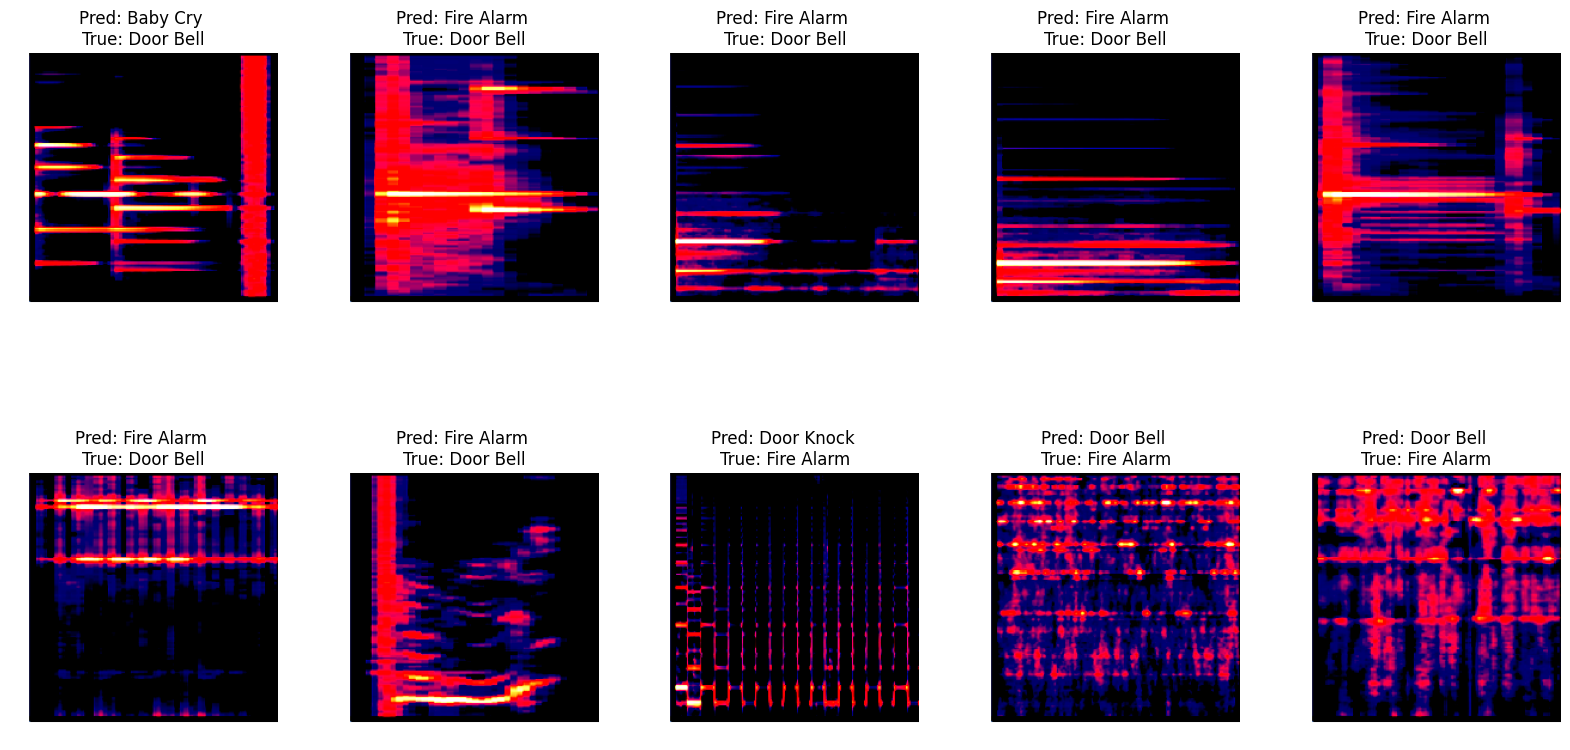

In [12]:
# Function to plot the wrong predictions
def plot_wrong_predictions(wrong_predictions, class_names, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(min(num_images, len(wrong_predictions))):
        img, pred_label, true_label = wrong_predictions[i]
        img = img.permute(1, 2, 0).numpy()  # Convert from tensor format

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Pred: {class_names[pred_label]} \nTrue: {class_names[true_label]}')
        plt.axis('off')
    plt.show()

# Plot some of the wrong predictions
plot_wrong_predictions(wrong_predictions, class_names)

# predicting the model

In [13]:
from PIL import Image
# Function to predict the class for a single input image
def predict_image(model, image_path, class_names):
    model.eval()  # Set model to evaluation mode
    image = Image.open(image_path).convert('RGB')
    image = test_transforms(image).unsqueeze(0)  # Apply transformations and add batch dimension

    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds.item()]

    return predicted_class

# Assuming class_names is a list of class names corresponding to the classes in your dataset
class_names = test_dataset.classes

# Predict the class for an input image
image_path = "C:\\Users\\PC\\Desktop\\lisnen_data\\Melspectrograms\\Melspectrograms\\Door_Bell\\doorbell_audio-2.png"
predicted_class = predict_image(model, image_path, class_names)
print(f'Predicted Class: {predicted_class}')

Predicted Class: Door_Bell_Melspectrorams
